# Implementing our novel approach with Naive Bayes

> Preprocessing: Clean and preprocess your dataset. This may include handling missing values, encoding categorical variables, and scaling features.

## Load dataset

In [20]:
from libs import data
from libs import kde_lib
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from libs.exp_lib import Density_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
from sklearn.datasets import make_circles, make_moons, make_classification
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import load_iris,load_breast_cancer
from libs.RNB import RobustNaiveBayes

def generate_outliers(X,y,outlier_proportion=.1):

    # Calculate the number of outliers to add
    num_outliers = int(outlier_proportion * len(X))
    # Generate random outlier points within the range of the dataset
    outliers_X = np.random.rand(num_outliers, 2) * (np.max(X, axis=0) - np.min(X, axis=0)) + np.min(X, axis=0)
    outliers_y = np.array([1] * num_outliers)  # Assign a class label to outliers

    # Concatenate outliers with the original dataset
    X = np.vstack((X, outliers_X))
    y = np.concatenate((y, outliers_y))
    return X, y

#X0, y0 = data.load_data_outlier("banana") # OK

# =======================================================
#   Generate synthetic data with outliers
# =======================================================
#X0, y0 = make_moons(500, noise=.2, random_state=42)
X0, y0 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0,random_state=1, n_clusters_per_class=1) 

#X0, y0 = generate_outliers(X0, y0)
""" data = load_breast_cancer()
X0, y0 = data.data, data.target
selected_features = [0, 3] 
X0 = X0[:,selected_features] """
# Introduce outliers by modifying some data points
outlier_proportion = .15
num_outliers = int(outlier_proportion * len(X0))
outliers_indices = np.random.choice(len(X0), num_outliers, replace=False)
outliers = np.random.uniform(low=np.min(X0, axis=0)-1, high=np.max(X0, axis=0)+1, size=(num_outliers, 2))
X0[outliers_indices] = outliers
# Set labels for the outliers
sep = int(len(outliers_indices)/2)
y0[outliers_indices[:sep]] = 1 
y0[outliers_indices[sep:]] = 0 

""" rng = np.random.RandomState(2)
X0 += 2 * rng.uniform(size=X0.shape) """
linearly_separable = (X0, y0)
# =======================================================
#   Done Generate  the synthetic data
# =======================================================

## Prepare the data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, random_state=42)

## Naive Bayes


In [22]:
model = GaussianNB()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(np.unique(predictions))

print("\n")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions )
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1)


[0 1]


Accuracy 2: 0.8333333333333334
precision 2: 0.8666666666666667
recall 2: 0.8125
f1 2: 0.8387096774193549


## Robust Naive Bayes with HHO

In [23]:
# Create and fit the RobustNaiveBayes classifier
model = RobustNaiveBayes()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(np.unique(predictions))

print("\n")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions )
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1)

2023/09/06 07:49:24 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].
2023/09/06 07:49:25 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.005508040918252952, Global best: 0.005508040918252952, Runtime: 0.74763 seconds
2023/09/06 07:49:26 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.005508040918252952, Global best: 0.005508040918252952, Runtime: 0.41512 seconds
2023/09/06 07:49:26 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.005508040918252952, Global best: 0.005508040918252952, Runtime: 0.47548 seconds
2023/09/06 07:49:27 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.005508040918252952, Global best: 0.005508040918252952, Runtime: 0.68976 seconds
2023/09/06 07:49:28 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.005508040918252952, Global 

Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations


2023/09/06 07:49:32 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.004074029802702269, Global best: 0.004074029802702269, Runtime: 0.60216 seconds
2023/09/06 07:49:33 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.004074029802702269, Global best: 0.004074029802702269, Runtime: 0.66718 seconds
2023/09/06 07:49:34 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.004074029802702269, Global best: 0.004074029802702269, Runtime: 0.47665 seconds
2023/09/06 07:49:34 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.004074029802702269, Global best: 0.004074029802702269, Runtime: 0.50098 seconds
2023/09/06 07:49:35 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.004074029802702269, Global best: 0.004074029802702269, Runtime: 0.65762 seconds
2023/09/06 07:49:36 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem:

Result hho_bandwith_selection: [1.]
Stop at 8 iterations
Stop at 16 iterations
[0 1]


Accuracy 2: 0.8466666666666667
precision 2: 0.8433734939759037
recall 2: 0.875
f1 2: 0.8588957055214724


## Robust Naive Bayes with PSO

In [24]:
# Create and fit the RobustNaiveBayes classifier
model = RobustNaiveBayes("pso")
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(np.unique(predictions))

print("\n")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions )
print("Accuracy 2:", accuracy)
print("precision 2:", precision)
print("recall 2:", recall)
print("f1 2:", f1)

Result pso_bandwith_selection: 1.0
Stop at 6 iterations
Stop at 100 iterations
Result pso_bandwith_selection: 1.0
Stop at 8 iterations
Stop at 16 iterations
[0 1]


Accuracy 2: 0.8466666666666667
precision 2: 0.8433734939759037
recall 2: 0.875
f1 2: 0.8588957055214724


## Classifiers Comparaison 

In [8]:
# =======================================================
#   Generate synthetic data with outliers
# =======================================================
#make_moons = make_moons(500, noise=.2, random_state=42)

#X0, y0 = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0,random_state=1, n_clusters_per_class=1) 

 # Introduce outliers by modifying some data points
""" outlier_proportion = .1
num_outliers = int(outlier_proportion * len(X0))
outliers_indices = np.random.choice(len(X0), num_outliers, replace=False)
outliers = np.random.uniform(low=np.min(X0, axis=0)-1, high=np.max(X0, axis=0)+1, size=(num_outliers, 2))
X0[outliers_indices] = outliers
# Set labels for the outliers
y0[outliers_indices] = 1  """
#X0, y0 = generate_outliers(X0, y0)
""" data = load_breast_cancer()
X0, y0 = data.data, data.target
selected_features = [0, 3] 
X0 = X0[:,selected_features] """

""" rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)  """
#X, y = data.load_data("banana")
# =======================================================
#   Done Generate  the synthetic data
# =======================================================
classifiers = {
    "Naive Bayes": GaussianNB(),
    "RNB with HHO": RobustNaiveBayes(),
    "RNB with PSO": RobustNaiveBayes("pso"),
}


#iris = load_iris()

datasets = [
    linearly_separable
]
datasets_name = [
    #"make_moons",
   # "make_circles ",
    "make_classification",
]

figure = plt.figure(figsize=(27, 9))
i = 1

<Figure size 2700x900 with 0 Axes>

2023/09/06 07:08:42 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: Solving 2-objective optimization problem with weights: [1 1].
2023/09/06 07:08:42 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.00806114259324936, Global best: 0.00806114259324936, Runtime: 0.43979 seconds
2023/09/06 07:08:43 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.0071935814849300875, Global best: 0.0071935814849300875, Runtime: 0.56800 seconds
2023/09/06 07:08:43 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.0071935814849300875, Global best: 0.0071935814849300875, Runtime: 0.50655 seconds
2023/09/06 07:08:44 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.0071935814849300875, Global best: 0.0071935814849300875, Runtime: 0.55498 seconds
2023/09/06 07:08:45 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.0071935814849300875, Gl

Result hho_bandwith_selection: [1.]
Stop at 6 iterations
Stop at 100 iterations


2023/09/06 07:08:49 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 1, Current best: 0.003971287912351434, Global best: 0.003971287912351434, Runtime: 0.43530 seconds
2023/09/06 07:08:49 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 2, Current best: 0.003469729543542471, Global best: 0.003469729543542471, Runtime: 0.51023 seconds
2023/09/06 07:08:50 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 3, Current best: 0.003469729543542471, Global best: 0.003469729543542471, Runtime: 0.65408 seconds
2023/09/06 07:08:51 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 4, Current best: 0.003469729543542471, Global best: 0.003469729543542471, Runtime: 0.79443 seconds
2023/09/06 07:08:51 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem: P, Epoch: 5, Current best: 0.003469729543542471, Global best: 0.003469729543542471, Runtime: 0.79639 seconds
2023/09/06 07:08:52 PM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >Problem:

Result hho_bandwith_selection: [1.]
Stop at 7 iterations
Stop at 100 iterations
Result pso_bandwith_selection: 1.0
Stop at 6 iterations
Stop at 100 iterations
Result pso_bandwith_selection: 1.0
Stop at 7 iterations
Stop at 100 iterations


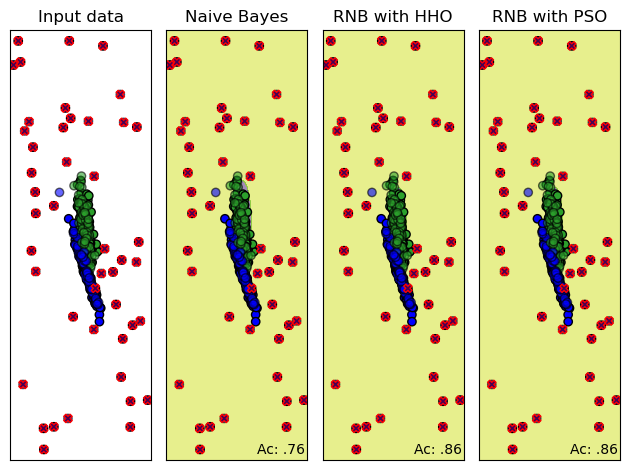

In [9]:
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#2ca02c", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) +1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    # Plot the Outliers points
    ax.scatter(X[outliers_indices, 0], X[outliers_indices, 1],marker="X", c=y[outliers_indices], edgecolors="r")
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in classifiers.items():
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # Create a meshgrid for plotting
        h = .02  # Step size in the mesh
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        #clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)

        # Make predictions using the classifier
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=.5)

        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        """ DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=.8, ax=ax, eps=.5
        ) """
        
        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )
        # Plot the Outliers points
        ax.scatter(X[outliers_indices, 0], X[outliers_indices, 1],marker="X", c=y[outliers_indices], edgecolors="r")
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("Ac: {}".format(("%.2f" % accuracy).lstrip("0"))),
            size=10,
            horizontalalignment="right",
        )
        i += 1
plt.tight_layout()
plt.show()